# Regression with a modular simulation model
* The semi empirical rudder is not part of the regression, but needs to be subtracted from the left hand side.
* Now also with propeller model!

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[07/03/23 13:49:31] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=339420;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=880976;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/03/23 13:49:37] INFO     Kedro project phd                                                      ]8;id=250352;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=110799;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=429212;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=349153;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=871943;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=856608;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=856072;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=567261;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=204862;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=944813;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=686394;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=691121;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=560046;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=494543;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=990677;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=168334;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=377853;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=5915;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
#fx_eq = fx_eq.subs(X_D,X_D_)
#fy_eq = fy_eq.subs(Y_D,Y_D_)
#mz_eq = mz_eq.subs(N_D,N_D_)

f_X_H = sp.Function('X_H')(u,v,r,delta)
f_Y_H = sp.Function('Y_H')(u,v,r,delta)
f_N_H = sp.Function('N_H')(u,v,r,delta)

f_X_R = sp.Function('X_R')(u,v,r,delta,thrust)
f_Y_R = sp.Function('Y_R')(u,v,r,delta,thrust)
f_N_R = sp.Function('N_R')(u,v,r,delta,thrust)

f_X_P = sp.Function('X_P')(u,v,r,rev)

eq_X_force = fx_eq.subs(X_D, f_X_H + f_X_R + f_X_P)
eq_Y_force = fy_eq.subs(Y_D, f_Y_H + f_Y_R)
eq_N_force = mz_eq.subs(N_D, f_N_H + f_N_R)

X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_H(u, v, r, delta) + X_P(u, v, r, rev) + X_R(u, v, r, delta, thrust))

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_H(u, v, r, delta) + Y_R(u, v, r, delta, thrust))

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v} + N_H(u, v, r, delta) + N_R(u, v, r, delta, thrust))

In [6]:
model_old= model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [7]:
parameters = dict(model_old.parameters)
params = {'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463}
parameters.update(params)
g_=9.81
parameters['g'] = g_

rudder_particulars = {
'x_R'   : ship_data['x_r'],
'y_R'   : 0,
'z_R'   : 0,
'A_R'   : 70/(ship_data['scale_factor']**2),
'b_R'   : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f'   :ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}

rudder_parameters = {
"C_L_tune" : 1.0,
#"delta_lim": np.deg2rad(40),
"delta_lim": 2*0.6981317007977318,
"kappa": 0.5, # (Small value means much flow straightening)
"nu":1.18849E-06,
}
parameters.update(rudder_parameters)

ship_parameters = ship_data.copy()
ship_parameters.update(rudder_particulars)
ship_parameters.update(prop_data)


In [8]:
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=parameters, 
                               control_keys=['delta','rev'], do_create_jacobian=False)

In [9]:
model_old_modular = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=parameters, 
                               control_keys=['delta','thrust'], do_create_jacobian=False)

## Add thrust prediction model

In [10]:
C0_w_p0,C1_w_p0,F_n = sp.symbols("C0_w_p0, C1_w_p0,F_n")
eq_w_p0 = sp.Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*F_n)

In [11]:
eq_F_n = sp.Eq(F_n,U/sp.sqrt(L*g))
eq_F_n

Eq(F_n, U/sqrt(L*g))

In [12]:
eq_w_p0 = eq_w_p0.subs(F_n, eq_F_n.rhs)
eq_w_p0

Eq(w_p0, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

Assuming that $w_{p0}$ is a good model:

In [13]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [14]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)
eq = sp.Eq(thrust,n_prop*solution[0][thrust_propeller])
eq

Eq(thrust, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [15]:
eq_X_P = sp.Eq(X_P, p.Xthrust*thrust)

In [16]:
propeller_equations = [eq, eq_X_P]
propellers = EquationSubSystem(ship=model, equations=propeller_equations, create_jacobians=False)
model.subsystems['propellers'] = propellers

In [17]:
propeller_equations_old_modular = [eq_X_P]
propellers_old_modular = EquationSubSystem(ship=model_old_modular, equations=propeller_equations_old_modular, create_jacobians=False)
model_old_modular.subsystems['propellers'] = propellers_old_modular

In [18]:
model_old_modular.subsystems['propellers'].equations['X_P']

Eq(X_P, X_{thrust}*thrust)

## Add semi-empirical rudder

In [19]:
rudders = SemiempiricalRudderSystem(ship=model, create_jacobians=False)
model.subsystems['rudders'] = rudders

## Add hull

In [20]:
eq_X_H = model_old.X_qs_eq.subs([
(X_D, X_H,),
(thrust,0),
(delta,0),
])

eq_Y_H = model_old.Y_qs_eq.subs([
(Y_D, Y_H,),
(delta,0),
(thrust,0),
])

eq_N_H = model_old.N_qs_eq.subs([
(N_D, N_H,),
(delta,0),
(thrust,0),

])

display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)


Eq(X_H, X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{r}*r + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_H, N_{r}*r + N_{ur}*r*u + N_{u}*u + N_{v}*v)

## Add polynomial rudder for the old modular model

In [21]:
eq_X_R_old = sp.Eq(f_X_R,model_old.X_qs_eq.rhs.subs(eq_X_H.rhs,0))
eq_Y_R_old = sp.Eq(f_Y_R,model_old.Y_qs_eq.rhs.subs(eq_Y_H.rhs,0))
eq_N_R_old = sp.Eq(f_N_R,model_old.N_qs_eq.rhs.subs(eq_N_H.rhs,0))
display(eq_X_R_old)
display(eq_Y_R_old)
display(eq_N_R_old)

Eq(X_R(u, v, r, delta, thrust), X_{deltadelta}*delta**2 + X_{thrust}*thrust)

Eq(Y_R(u, v, r, delta, thrust), Y_{delta}*delta + Y_{thrustdelta}*delta*thrust + Y_{thrust}*thrust + Y_{vvdelta}*delta*v**2)

Eq(N_R(u, v, r, delta, thrust), N_{delta}*delta + N_{thrustdelta}*delta*thrust + N_{thrust}*thrust + N_{vvdelta}*delta*v**2)

In [22]:
equations_rudders_old_modular = [eq_X_R_old, eq_Y_R_old, eq_N_R_old]
rudders_old_modular = PrimeEquationSubSystem(ship=model_old_modular, equations=equations_rudders_old_modular, create_jacobians=False)
model_old_modular.subsystems['rudders'] = rudders_old_modular

In [23]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull, create_jacobians=False)
model.subsystems['hull'] = hull

hull_old_modular = PrimeEquationSubSystem(ship=model_old_modular, equations=equations_hull, create_jacobians=False)
model_old_modular.subsystems['hull'] = hull_old_modular

## Regression

In [24]:
data = time_series_smooth['wpcc.updated.joined.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [25]:
df_forces = model.forces_from_motions(data=data)
data['fx'] = df_forces['fx']
data['fy'] = df_forces['fy']
data['mz'] = df_forces['mz']

<Axes: >

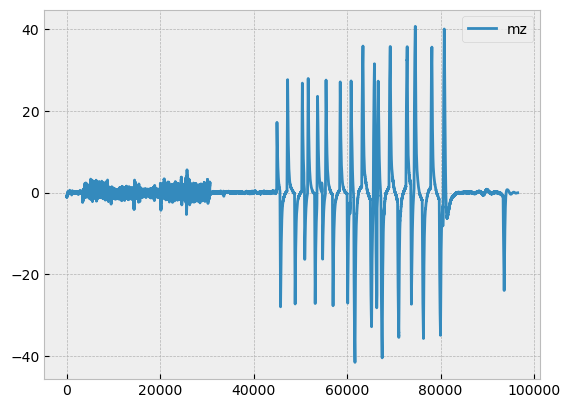

In [26]:
data.plot(y='mz')

In [27]:
eq_f_X_H = sp.Eq(f_X_H, sp.solve(model.X_eq, f_X_H)[0])
eq_f_Y_H = sp.Eq(f_Y_H, sp.solve(model.Y_eq, f_Y_H)[0])
eq_f_N_H = sp.Eq(f_N_H, sp.solve(model.N_eq, f_N_H)[0])


In [28]:
u_prime, v_prime = sp.symbols("u' v'")
subs = [
(u,u_prime),
(v,v_prime),
]

#eq_f_X_H = eq_f_X_H.subs(subs)
#eq_f_Y_H = eq_f_Y_H.subs(subs)
#eq_f_N_H = eq_f_N_H.subs(subs)

#subs_prime = [
#    (f_X_R,f_X_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#    (f_Y_R,f_Y_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#    (f_N_R,f_N_R/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**3)),
#    (f_X_P,f_X_P/(sp.Rational(1, 2) * rho * (u**2 + v**2) * L**2)),
#]
#
#eq_f_X_H = eq_f_X_H.subs(subs_prime)
#eq_f_Y_H = eq_f_Y_H.subs(subs_prime)
#eq_f_N_H = eq_f_N_H.subs(subs_prime)

display(eq_f_X_H)
display(eq_f_Y_H)
display(eq_f_N_H)


Eq(X_H(u, v, r, delta), -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v - X_P(u, v, r, rev) - X_R(u, v, r, delta, thrust))

Eq(Y_H(u, v, r, delta), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u - Y_R(u, v, r, delta, thrust))

Eq(N_H(u, v, r, delta), I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + \dot{v}*m*x_G + m*r*u*x_G - N_R(u, v, r, delta, thrust))

In [29]:
states_str = [str(state.subs(subs_simpler)).replace('_','') for state in model.states]

In [76]:
states_str

['x0', 'y0', 'psi', 'u', 'v', 'r']

In [77]:
model.control_keys

['delta', 'rev']

In [80]:
model.subsystems['hull'].equations['X_H']

Eq(X_H, X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [74]:
calculation = model.calculate_forces(states_dict=data[states_str], control=data[model.control_keys])
calculation_ = {
'X_R': calculation['X_R'],
'Y_R': calculation['Y_R'],
'N_R': calculation['N_R'],
'X_P': calculation['X_P'],
'thrust':calculation['thrust'],
}


calculation_prime = model.prime_system.prime(calculation_, U=data['U'])


In [31]:
data_prime = model.prime_system.prime(data[states_str+['u1d','v1d','r1d','fx','fy','mz','rev']], U=data['U'])
data_prime['X_R'] = calculation_prime['X_R']
data_prime['Y_R'] = calculation_prime['Y_R']
data_prime['N_R'] = calculation_prime['N_R']
data_prime['X_P'] = calculation_prime['X_P']
data_prime['thrust'] = calculation_prime['thrust']

In [32]:
eqs = [eq_f_X_H, eq_f_Y_H, eq_f_N_H]
lambdas = {eq.lhs.name:lambdify(eq.rhs.subs(subs_simpler), substitute_functions=True) for eq in eqs} 

In [33]:
for key, lambda_ in lambdas.items():

    data_prime[key] = run(lambda_, 
        inputs=data_prime, 
        **calculation_prime, 
        **model.ship_parameters_prime, 
        **model.parameters)

In [34]:
data_prime[['X_H','Y_H','N_H']]

,X_H,Y_H,N_H
0,-0.000801,-0.000077,-0.000026
1,-0.000782,-0.000077,-0.000025
2,-0.000770,-0.000077,-0.000025
3,-0.000750,-0.000076,-0.000025
4,-0.000744,-0.000076,-0.000025
...,...,...,...
96495,-0.000665,0.000125,0.000004
96496,-0.000655,0.000125,0.000004
96497,-0.000634,0.000125,0.000004
96498,-0.000639,0.000124,0.000004


In [35]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2}

In [36]:
hull.equations['X_H']

Eq(X_H, X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [37]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2}

In [38]:
exclude_parameters = {
'Xthrust' : model_old.parameters['Xthrust']
}

In [39]:
eq = hull.equations['X_H']

eq_to_matrix_X_H = DiffEqToMatrix(eq, label=X_H, base_features=[u,v,r,thrust], exclude_parameters=exclude_parameters)

eq = hull.equations['Y_H'].subs(thrust,0)
eq_to_matrix_Y_H = DiffEqToMatrix(eq, label=Y_H, base_features=[u,v,r])

eq = hull.equations['N_H'].subs(thrust,0)
eq_to_matrix_N_H = DiffEqToMatrix(eq, label=N_H, base_features=[u,v,r])


In [40]:
new_parameters = {key:value for key,value in parameters.items() if 'dot' in key}
new_parameters['Xthrust'] = model_old.parameters['Xthrust']

In [81]:
models = {}
for eq_to_matrix in [eq_to_matrix_X_H, eq_to_matrix_Y_H, eq_to_matrix_N_H]:
    key = eq_to_matrix.acceleration_equation.lhs.name
    X,y = eq_to_matrix.calculate_features_and_label(data=data_prime, y=data_prime[key])
    ols = sm.OLS(y,X)
    models[key] = ols_fit = ols.fit()
    new_parameters.update(ols_fit.params)

In [42]:
for key,fit in models.items():
    display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    X_H   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          2.430e+06
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        13:49:52   Log-Likelihood:                      7.6035e+05
No. Observations:               96500   AIC:                                 -1.521e+06
Df Residuals:                   96496   BIC:                                 -1.521e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xrr           -0.0046   1.87e-05   -243.045      0.000      -0.005      -0.005
Xuu            0.0154      0.000    108.052      0.000       0.015       0.016
Xu            -0.0162      0.000   -114.021      0.000      -0.016      -0.016
Xvr           -0.0108   6.51e-05   -165.816      0.000      -0.011      -0.011
==============================================================================
Omnibus:                    13600.680   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           165087.036
Skew:                          -0.248   Prob(JB):                         0.00
Kurtosis:                       9.388   Cond. No.                         992.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Y_H   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.839e+06
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        13:49:52   Log-Likelihood:                      6.3228e+05
No. Observations:               96500   AIC:                                 -1.265e+06
Df Residuals:                   96496   BIC:                                 -1.265e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yr             0.0786      0.000    510.467      0.000       0.078       0.079
Yur           -0.0796      0.000   -521.694      0.000      -0.080      -0.079
Yu         -2.044e-05    1.2e-06    -17.052      0.000   -2.28e-05   -1.81e-05
Yv            -0.0158   3.03e-05   -520.544      0.000      -0.016      -0.016
==============================================================================
Omnibus:                    76099.770   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2655858.557
Skew:                          -3.541   Prob(JB):                         0.00
Kurtosis:                      27.706   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    N_H   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          9.557e+05
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        13:49:52   Log-Likelihood:                      7.0732e+05
No. Observations:               96500   AIC:                                 -1.415e+06
Df Residuals:                   96496   BIC:                                 -1.415e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nr            -0.0442   7.08e-05   -624.849      0.000      -0.044      -0.044
Nur            0.0422   7.01e-05    602.018      0.000       0.042       0.042
Nu         -6.625e-06   5.51e-07    -12.029      0.000    -7.7e-06   -5.55e-06
Nv            -0.0023   1.39e-05   -161.683      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    94100.949   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4995231.770
Skew:                           4.815   Prob(JB):                         0.00
Kurtosis:                      36.906   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

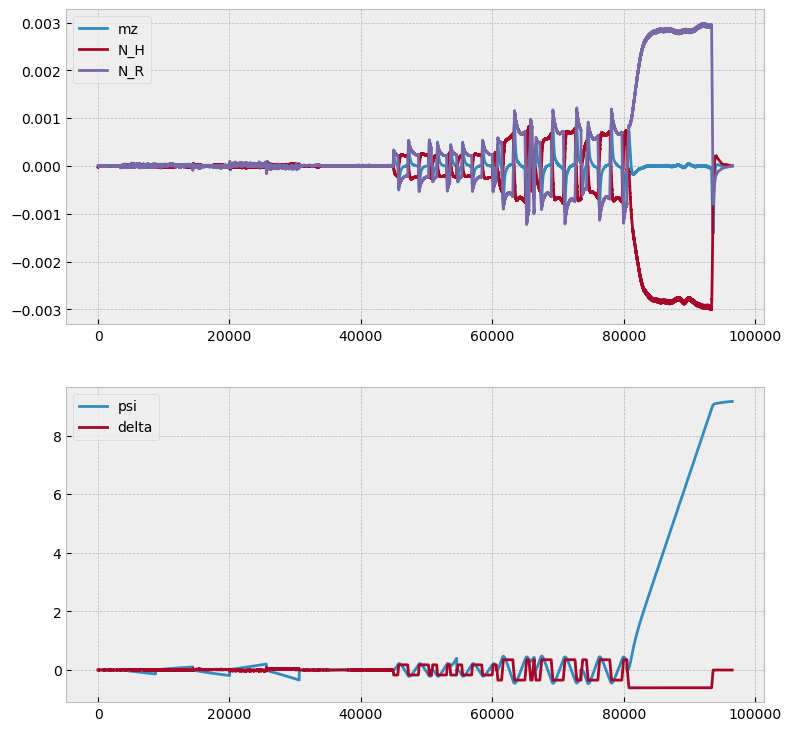

In [43]:
fig,axes=plt.subplots(nrows=2)
fig.set_size_inches(9,9)
ax=axes[0]
data_prime.plot(y=['mz','N_H','N_R'], ax=ax)
#data_prime['mz_'] = data_prime['N_H'] + data_prime['N_R']
#data_prime.plot(y='mz_', style='--', ax=ax)

ax=axes[1]
data.plot(y='psi', ax=ax)
data.plot(y='delta', ax=ax)


In [44]:
df_parameters = pd.concat((
    pd.Series(parameters, name='SLIC'),
    pd.Series(new_parameters, name='modular'),
),axis=1).transpose()

<Axes: >

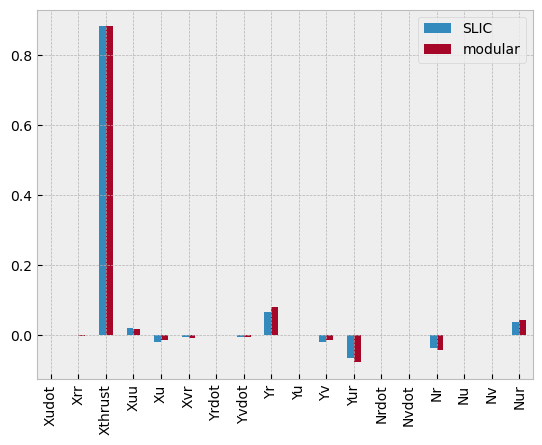

In [45]:
df_parameters.dropna(axis=1).transpose().plot.bar()

In [46]:
new_parameters.update(rudder_parameters)
new_parameters.update(params)
g_=9.81
new_parameters['g'] = g_

In [47]:
model2 = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                               ship_parameters=ship_parameters, 
                               parameters=new_parameters, 
                               control_keys=['delta','rev'], do_create_jacobian=False)

propellers2 = EquationSubSystem(ship=model2, equations=propeller_equations, create_jacobians=False)
model2.subsystems['propellers'] = propellers2

rudders2 = SemiempiricalRudderSystem(ship=model2, create_jacobians=False)
model2.subsystems['rudders'] = rudders2
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull2 = PrimeEquationSubSystem(ship=model2, equations=equations_hull, create_jacobians=False)
model2.subsystems['hull'] = hull2

## Save model

In [48]:
model_loader["MDL_modular_propeller_rudder"] = model2
catalog.save(f"{ship}.models",model_loader)

[07/03/23 13:49:59] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=716247;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=820568;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [49]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

In [50]:
result2 = model2.simulate(data)

In [51]:
result_old_modular = model_old_modular.simulate(data)

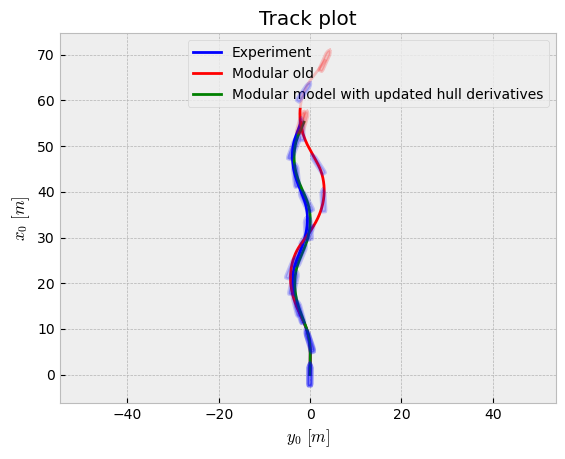

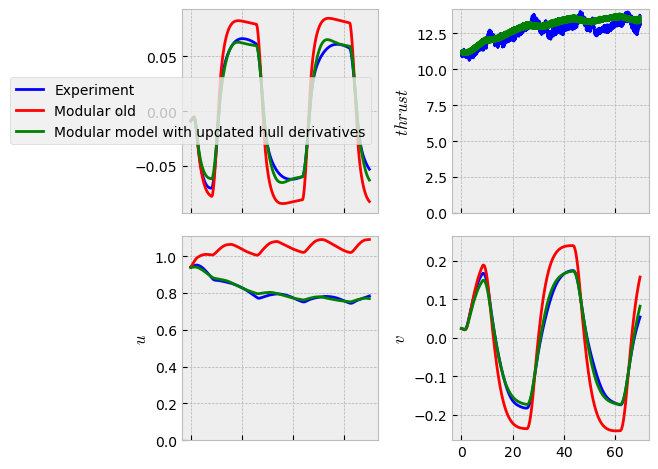

In [52]:
dataframes = {
              'Experiment':data,
              'Modular old':result_old_modular,
              'Modular model with updated hull derivatives':result2,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [53]:
model_old_modular.subsystems['hull'].equations['X_H']

Eq(X_H, X_{rr}*r**2 + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [54]:
result_old_modular.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,X_P,X_R,Y_R,N_R,X_H,Y_H,N_H,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.024495,-0.002389,0.003981,9.882972,9.882972,-0.000315,0.000763,-9.146405,-5.270261,4.546532,10.619540,-5.270576,4.547296,-0.025223,0.939521
0.01,0.939469,0.023671,-0.008840,0.006528,-0.036697,0.007784,0.024625,-0.002405,0.003965,9.913058,9.913058,-0.000631,0.001528,-9.151287,-5.269157,4.526125,10.674828,-5.269788,4.527652,-0.025191,0.939767
0.02,0.939719,0.023647,-0.008800,0.015922,-0.036388,0.007696,0.024643,-0.002420,0.003948,9.919295,9.919295,-0.000631,0.001528,-9.156242,-5.268023,4.505815,10.682348,-5.268654,4.507344,-0.025159,0.940016
0.03,0.939963,0.023623,-0.008761,0.025319,-0.036079,0.007608,0.024489,-0.002436,0.003931,9.888365,9.888365,-0.000631,0.001529,-9.161086,-5.266803,4.485558,10.615645,-5.267434,4.487087,-0.025126,0.940260
0.04,0.940203,0.023598,-0.008722,0.034717,-0.035772,0.007521,0.024153,-0.002451,0.003914,9.818277,9.818277,-0.000632,0.001530,-9.165842,-5.265504,4.465359,10.470713,-5.266136,4.466889,-0.025094,0.940499


<Axes: >

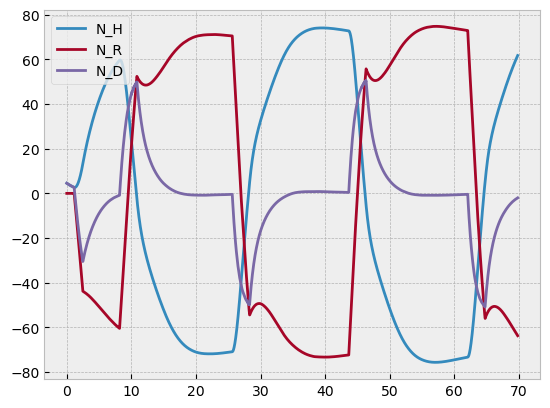

In [55]:
result_old_modular.plot(y=['N_H','N_R','N_D'])

<Axes: >

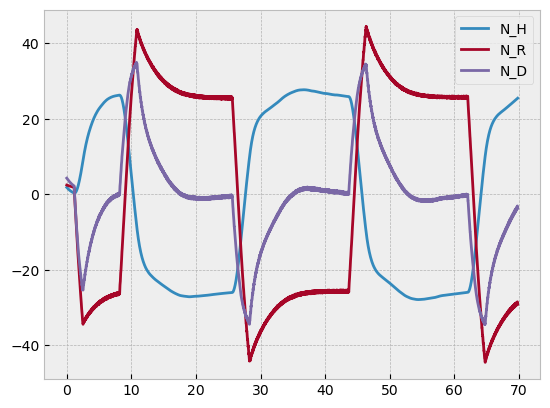

In [56]:
result2.plot(y=['N_H','N_R','N_D'])

<Axes: >

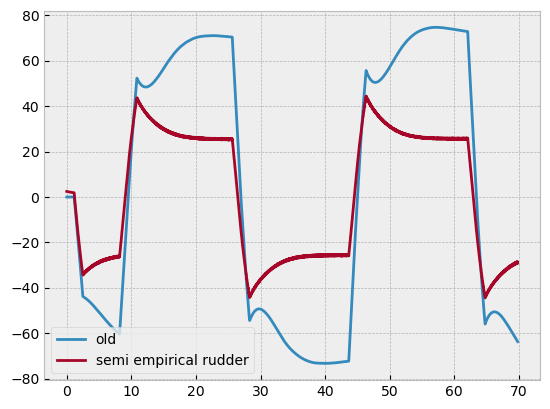

In [57]:
fig,ax=plt.subplots()
result_old_modular.plot(y='N_R', ax=ax, label='old')
result2.plot(y='N_R', ax=ax, label='semi empirical rudder')


<Axes: >

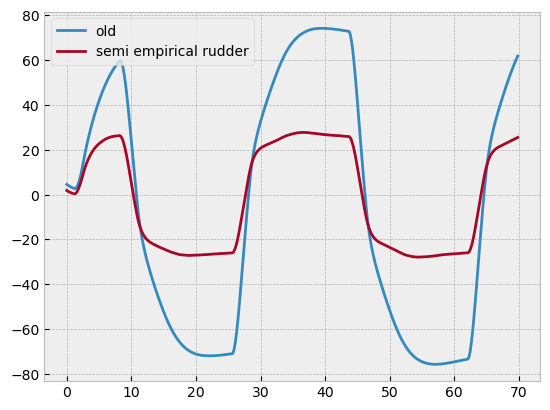

In [58]:
fig,ax=plt.subplots()
result_old_modular.plot(y='N_H', ax=ax, label='old')
result2.plot(y='N_H', ax=ax, label='semi empirical rudder')


In [59]:
data['delta']

0.000000    -0.000007
0.010000    -0.000014
0.020000    -0.000014
0.030000    -0.000014
0.040000    -0.000014
               ...   
69.780004    0.349065
69.790004    0.349078
69.800004    0.349078
69.810004    0.349065
69.820004    0.349078
Name: delta, Length: 6983, dtype: float64

<Axes: >

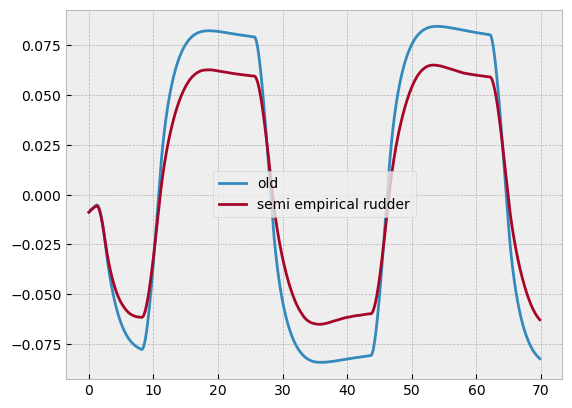

In [60]:
fig,ax=plt.subplots()
result_old_modular.plot(y='r', ax=ax, label='old')
result2.plot(y='r', ax=ax, label='semi empirical rudder')

In [61]:
result2.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.001110,-0.002232,0.003751,11.271166,9.952440,1.144697,-0.037457,-0.056504,-1.013584,2.455102,-9.326026,-4.149080,1.830808,0.569910,-5.162663,4.285910,-0.025223,0.939521
0.01,0.939234,0.023673,-0.008842,0.006527,-0.036697,0.007784,0.001147,-0.002244,0.003731,11.288242,9.967518,1.145247,-0.037358,-0.056506,-1.011880,2.450974,-9.325928,-4.147020,1.811153,0.585084,-5.158900,4.262127,-0.025199,0.939532
0.02,0.939246,0.023650,-0.008805,0.015918,-0.036388,0.007696,0.001109,-0.002253,0.003709,11.269046,9.950567,1.144640,-0.037285,-0.056415,-1.008815,2.443550,-9.325843,-4.144931,1.791637,0.568309,-5.153745,4.235187,-0.025175,0.939543
0.03,0.939256,0.023628,-0.008768,0.025308,-0.036079,0.007608,0.000929,-0.002260,0.003682,11.180704,9.872562,1.141823,-0.037283,-0.056160,-1.003823,2.431459,-9.325739,-4.142806,1.772279,0.490663,-5.146629,4.203739,-0.025150,0.939553
0.04,0.939266,0.023605,-0.008731,0.034698,-0.035772,0.007521,0.000976,-0.002271,0.003662,11.202914,9.892173,1.142537,-0.037168,-0.056169,-1.001948,2.426918,-9.325619,-4.140647,1.753076,0.510385,-5.142595,4.179994,-0.025126,0.939562


In [62]:
rudders2.equations.keys()

dict_keys(['V_x', 'C_L', 'X_R', 'Y_R', 'N_R'])

In [63]:
rudders2.equations['V_x']

Eq(V_x, r_0**2*u*(1 - w_f)*(0.02823576*pi**(5/2)*n_prop*r_0**3*rho*u**2*sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))*(1 - w_f)**2 + 0.00941192*pi**3*n_prop*r_0**3*rho*u**2*(1 - w_f)**2 + pi**(3/2)*n_prop*rho*u**2*((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))**(3/2)*(1 - w_f)**2*(19.4030100757589*r_0**3*(x/r_0)**(3/2)*sqrt((sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2)) + sqrt(pi))/sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))) + 0.00941192*r_0**3 + 10000.0*x**3) + pi**2*r_0*(19.4030100757589*(x/r_0)**(3/2)*sqrt((sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2)) + sqrt(pi))/sqrt((pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust)/(n_prop*r_0**2*rho*u**2*(1 - w_f)**2))) + 0.02823576)*(pi*n_prop*r_0**2*rho*u**2*(1 - w_f)**2 + 2*thrust))/(sqrt(pi)*(pi*

In [64]:
states_dict = {
'x0':0,
'y0':0,
'psi':0,
'u':data['u'].mean(),
'v':0,
'r':0,
}

control={
'delta':0,
'thrust':data['thrust'].mean(),
}
rudders2.calculate_forces(states_dict=states_dict, control=control, calculation={})

{'V_x': 1.132833216673252,
 'C_L': 0.0,
 'X_R': -0.04652826145010509,
 'Y_R': 0.0,
 'N_R': -0.0}

In [65]:
states_dict

{'x0': 0,
 'y0': 0,
 'psi': 0,
 'u': 0.8075123973077567,
 'v': 0,
 'r': 0,
 'U': 0.8075123973077567}

In [66]:
model2.ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2,
 'x_R': -2.42219908951329,
 'y_R': 0,
 'z_R': 0,
 'A_R': 0.041238571024601746,
 'b_R': 0.17427184466019416,
 'w_f': 0.151,
 'r_0': 0.06067961165048543,
 'x': 0.1}

In [67]:
model2.ship_parameters['b_R'] = 1.0*0.17427184466019416
model2.parameters['C_L_tune']=1
model2.parameters['delta_lim'] = 2*0.6981317007977318

In [68]:
model2.parameters

{'Xudot': 0.00017880704448812042,
 'Yrdot': -0.00030313777458141895,
 'Yvdot': -0.006109387408263365,
 'Nrdot': -0.00029867482773178765,
 'Nvdot': -0.00012825440172375716,
 'Xthrust': 0.883,
 'Xrr': -0.004553380208509592,
 'Xuu': 0.015369690498373199,
 'Xu': -0.01620806754315444,
 'Xvr': -0.010792544700955052,
 'Yr': 0.07861028341333619,
 'Yur': -0.07957782359412396,
 'Yu': -2.0438162395676452e-05,
 'Yv': -0.015783939387969386,
 'Nr': -0.044213300616288725,
 'Nur': 0.04219414254385953,
 'Nu': -6.624631418911465e-06,
 'Nv': -0.0022526238960708725,
 'C_L_tune': 1,
 'delta_lim': 1.3962634015954636,
 'kappa': 0.5,
 'nu': 1.18849e-06,
 'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463,
 'g': 9.81}

In [69]:
df_ = pd.DataFrame()
df_['delta'] = np.deg2rad(np.linspace(-35,35,100))
df_['rev'] = data['rev'].mean()
df_['x0']=0
df_['y0']=0
df_['psi']=0
df_['u'] = data['u'].mean()
df_['v']=0
df_['r']=0

calculation2 = propellers2.calculate_forces(states_dict=df_, control=df_[model2.control_keys], calculation={})
calculation2 = rudders2.calculate_forces(states_dict=df_, control=df_[model.control_keys], calculation=calculation2)
df2_ = pd.concat((df_,pd.DataFrame(calculation2, index=df_.index)), axis=1)

df_ = pd.DataFrame()
df_['delta'] = np.deg2rad(np.linspace(-35,35,100))
df_['thrust'] = data['thrust'].mean()
df_['x0']=0
df_['y0']=0
df_['psi']=0
df_['u'] = data['u'].mean()
df_['v']=0
df_['r']=0

calculation = rudders_old_modular.calculate_forces(states_dict=df_, control=df_[model_old_modular.control_keys], calculation={})
df1_ = pd.concat((df_,pd.DataFrame(calculation, index=df_.index)), axis=1)

<Axes: xlabel='delta'>

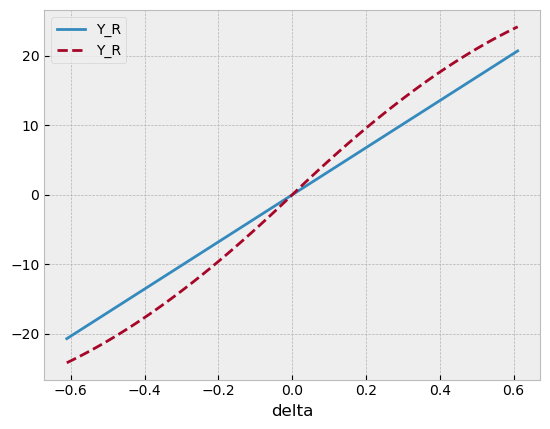

In [70]:
fig,ax=plt.subplots()
df1_.plot(x='delta', y='Y_R', ax=ax)
df2_.plot(x='delta', y='Y_R', style='--',ax=ax)
